In [13]:
%matplotlib notebook

import sys
import os
import time
import logging
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt

logger = logging.getLogger('cqed')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.WARNING)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

In [2]:
import qcodes as qc
import broadbean as bb
from broadbean.plotting import plotter

In [3]:
from pytopo.mplplots import init_nb_plotting; reload(init_nb_plotting)
from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots

In [15]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.rf import alazar_detector; reload(alazar_detector)
from pytopo.rf.alazar_detector import AlazarDetector

from cqed import broadbean; reload(broadbean)
from cqed.broadbean import BroadBeanSequence, BluePrints

from cqed import bb_sequences; reload(bb_sequences)
from cqed.bb_sequences import TriggeredReadoutSequence, TwoToneSSBSequence

# Initialize

## Global settings

In [16]:
qc.config['core']['db_location'] = "D:\OneDrive\Setups\LK1\LK1_data\experiments.db"

BroadBeanSequence.chan_map = {
    1 : ['src_I', 'ro_trigger', 'ro_gate'],
    2 : ['src_Q', 'src_gate', None],
}
BroadBeanSequence.chan_settings[1]['Vpp'] = 2.0
BroadBeanSequence.chan_settings[2]['Vpp'] = 2.0

BroadBeanSequence.sweep_wait = None

TriggeredReadoutSequence.chan_map = {
    1 : ['FILL.1', 'ro_trigger', 'ro_gate'],
#     2 : ['FILL.2', 'src_gate', None]
}

## Create instruments

In [10]:
inst_list = []

# Alazar
from qcodes.instrument_drivers.AlazarTech import utils; reload(utils)
from qcodes.instrument_drivers.AlazarTech import ATS9870; reload(ATS9870)
from qcodes.instrument_drivers.AlazarTech.ATS9870 import AlazarTech_ATS9870
alazar = instools.create_inst(AlazarTech_ATS9870, 'alazar', force_new_instance=True)
inst_list.append(alazar)

# Alazar aquisition controllers
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgDemodCtl, AvgIQCtl

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

avgdemod_acq = instools.create_inst(AvgDemodCtl, 'avgdemod_acq', 'alazar', force_new_instance=True)
inst_list.append(avgdemod_acq)

avgiq_acq = instools.create_inst(AvgIQCtl, 'avgiq_acq', 'alazar', force_new_instance=True)
inst_list.append(avgiq_acq)

# RF sources
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20", force_new_instance=True)
inst_list.append(LO)

RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.29.172", force_new_instance=True)
inst_list.append(RF)

from qcodes.instrument_drivers.agilent.E8267C import E8267
S1 = instools.create_inst(E8267, 'S1', address='GPIB0::19::INSTR', force_new_instance=True)
inst_list.append(S1)

from pytopo.rf.sources import HeterodyneSource
hetsrc = instools.create_inst(HeterodyneSource, 'hetsrc', RF=RF, LO=LO, force_new_instance=True)
inst_list.append(hetsrc)

# AWG and sequences
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg = instools.create_inst(Tektronix_AWG5014, 'awg', address='TCPIP0::169.254.193.163::inst0::INSTR', force_new_instance=True)
inst_list.append(awg)

station = qc.Station(*inst_list)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110435, firmware:3.1.19.15-3.50.124.67) in 0.06s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110433, firmware:3.1.19.15-3.50.124.67) in 0.02s
Connected to: Agilent Technologies E8267D (serial:US50350091, firmware:C.06.10) in 0.07s
Connected to: TEKTRONIX AWG5014C (serial:B010125, firmware:SCPI:99.0 FW:4.1.1.5) in 0.22s


## Default (instrument) settings

In [11]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(int(1e9))
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.external_sample_rate(int(1e9))
    alazar.decimation(1)
    alazar.coupling1('AC')
    alazar.coupling2('AC')
    alazar.channel_range1(0.1)
    alazar.channel_range2(0.1)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_source1('CHANNEL_A')
    alazar.trigger_level1(128 + 5)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_5V')
    alazar.trigger_delay(0)
    alazar.timeout_ticks(int(1e7))
    
    
hetsrc.frequency(5e9)
hetsrc.IF(20e6)
hetsrc.RF.on()
hetsrc.LO.on()
hetsrc.RF.power(-10)
hetsrc.LO.power(15)

S1.power(15)
S1.frequency(4.8e9)
S1.modulation_rf('ON')
S1.pulse_modulation_state('ON')
S1.pulse_modulation_source('EXT')
S1.output_rf('OFF')

def awg_trigger_func(do_start):
    if do_start:
        station.awg.start()
    else:
        station.awg.stop()
        
for ctl in [raw_acq, avgdemod_acq, avgiq_acq]:
    ctl.trigger_func = awg_trigger_func

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:522: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."


## Test RF acquisition

### CW

Simple CW test. Make sure something is playing if you execute this, or trigger won't work.

In [ ]:
with alazar.syncing():
    alazar.trigger_source1('CHANNEL_A')
    
hetsrc.RF.frequency(5e9)
hetsrc.IF(20e6)
RF.pulsemod_state('off')    

raw_acq.update_acquisitionkwargs(
    samples_per_record=128*4,
    records_per_buffer=1,
    buffers_per_acquisition=1,
)
data = raw_acq.acquisition()

In [ ]:
fig, (ax, bx) = plt.subplots(2, 1)

ax.plot(data[0, 0, :, 0])
bx.plot(data[0, 0, :, 1])

### Pulsed measurement

Simple pulsed test. This pulses the RF and triggers the Alazar. To see something, make sure some of the RF signal makes is to the demodulation :)

#### Testing the acquisition without time integration

In [17]:
trig_ro_seq = create_inst(TriggeredReadoutSequence, 'trig_ro_seq', awg=awg, force_new_instance=True)
station = add2station(station, trig_ro_seq)

hetsrc.RF.frequency(5e9)
hetsrc.IF(25e6)
RF.pulsemod_state('on')
RF.pulsemod_source('ext')

with alazar.syncing():
    alazar.trigger_source1('EXTERNAL')

trig_ro_seq.pre_trigger_delay(1e-6)
trig_ro_seq.trigger_len(100e-9)
trig_ro_seq.post_trigger_delay(500e-9)
trig_ro_seq.readout_gate_len(2e-6)
trig_ro_seq.seq_len(10e-6)
trig_ro_seq.setup()

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:522: UserWarning: Using Internal clock but parameter external_sample_rate is set.This will have no effect and is ignored
  warnings.warn("Using Internal clock but parameter external_sample_rate is set."
2018-07-16 18:55:43,884 - cqed.bb_sequences - WARNING - No src_gate defined in channel map. Only readout gate pulse will be generated.
2018-07-16 18:55:43,884 - cqed.bb_sequences - WARNING - No src_gate defined in channel map. Only readout gate pulse will be generated.
2018-07-16 18:55:43,884 - cqed.bb_sequences - WARNING - No src_gate defined in channel map. Only readout gate pulse will be generated.


Instrument trig_ro_seq already exists.


In [18]:
# acq = raw_acq
acq = avgdemod_acq
acq.demod_frq(hetsrc.IF())

acq.acq_time(4e-6)
acq.update_acquisitionkwargs(
    records_per_buffer=10,
    buffers_per_acquisition=1,
    allocated_buffers=10,
)
data = acq.acquisition()
tvals = acq.tvals
if acq == avgdemod_acq:
    tvals = acq.demod_tvals

'allocated_buffers' should be <= 'buffers_per_acquisition'. Defaulting 'allocated_buffers' to 1


<IPython.core.display.Javascript object>


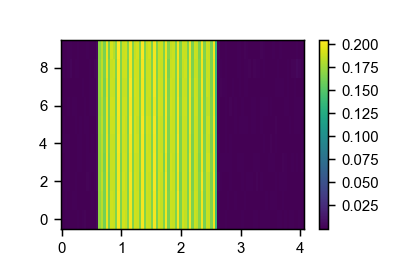

<IPython.core.display.Javascript object>


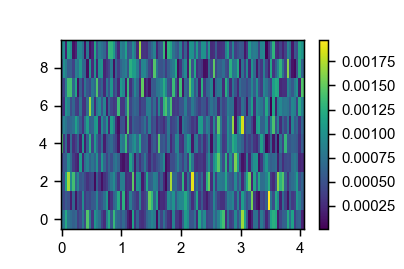

In [19]:
if acq == raw_acq and len(data.shape) == 4:
    fig, (ax, bx) = plt.subplots(2, 1, sharex=True, sharey=True)
    ax.plot(tvals * 1e6, data[0, 0, :, 0])
    bx.plot(tvals * 1e6, data[0, 0, :, 1])

elif acq == avgdemod_acq and len(data.shape) == 3 and data.shape[0] == 1:
    fig, (ax, bx) = plt.subplots(2, 1, sharex=True, sharey=True)
    ax.plot(tvals * 1e6, data[0, :, 0].real)
    ax.plot(tvals * 1e6, data[0, :, 0].imag)
    ax.plot(tvals * 1e6, np.abs(data[0, :, 0]))
    
    bx.plot(tvals * 1e6, data[0, :, 1].real)
    bx.plot(tvals * 1e6, data[0, :, 1].imag)
    bx.plot(tvals * 1e6, np.abs(data[0, :, 1]))
    
elif acq == avgdemod_acq and len(data.shape) == 3 and data.shape[0] > 1:
    fig, ax = plt.subplots(1 ,1, figsize=(3,2))
    im = mplplots.ppcolormesh(ax, tvals * 1e6, np.arange(data.shape[0]), np.abs(data[:, :, 0]))
    fig.colorbar(im)
    
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    im = mplplots.ppcolormesh(ax, tvals * 1e6, np.arange(data.shape[0]), np.abs(data[:, :, 1]))
    fig.colorbar(im)

#### Testing acquisition with time-integration

In [ ]:
trig_ro_seq = create_inst(TriggeredReadoutSequence, 'trig_ro_seq', awg=awg, force_new_instance=True)
trig_ro_seq.sweep_wait = None
station = add2station(station, trig_ro_seq)

hetsrc.RF.frequency(5e9)
hetsrc.IF(25e6)
RF.pulsemod_state('on')
RF.pulsemod_source('ext')

with alazar.syncing():
    alazar.trigger_source1('EXTERNAL')

trig_ro_seq.pre_trigger_delay(1e-6)
trig_ro_seq.trigger_len(100e-9)
trig_ro_seq.post_trigger_delay(500e-9)
trig_ro_seq.readout_gate_len(1e-6)
trig_ro_seq.seq_len(5e-6)
trig_ro_seq.setup()

In [ ]:
fvals = np.linspace(4.999, 5.001, 101) * 1e9
iqvals = []

for f in fvals:
    RF.frequency(f)
    time.sleep(0.1)
    
    acq = avgiq_acq
    acq.demod_frq(hetsrc.IF())

    acq.acq_time(1e-6)
    acq.update_acquisitionkwargs(
        records_per_buffer=1,
        buffers_per_acquisition=2,
        allocated_buffers=2,
    )
    data = acq.acquisition()
    iqvals.append(data)

In [ ]:
iq = np.array(iqvals).mean(axis=1)
print(iq.shape)

fig, (ax, bx) = plt.subplots(2, 1, sharex=True, sharey=True)
ax.plot(fvals * 1e-9, iq[:, 0].real)
ax.plot(fvals * 1e-9, iq[:, 0].imag)
ax.plot(fvals * 1e-9, np.abs(iq[:, 0]))

bx.plot(fvals * 1e-9, iq[:, 1].real)
bx.plot(fvals * 1e-9, iq[:, 1].imag)
bx.plot(fvals * 1e-9, np.abs(iq[:, 1]))

### Testing SSB

Simple Sequence on the AWG for SSB modulation. Hook up a spectrum analyzer to the RF output of the generator to test.

In [ ]:
ssb_seq = create_inst(TwoToneSSBSequence, 'ssb_seq', awg=awg, force_new_instance=True)
station = add2station(station, ssb_seq)

detector = create_inst(AlazarDetector, name='detector', acqctl=avgiq_acq, force_new_instance=True)
station = add2station(station, detector)

### Setting up physical instruments
with alazar.syncing():
    alazar.trigger_source1('EXTERNAL')

S1.frequency(5e9)
S1.power(-40)
S1.pulse_modulation_state('ON')
S1.pulse_modulation_source('EXT')
S1.modulation_rf('ON')
S1.output_rf('ON')

### Configure the sequence -- one frq is enough for checking...
ssb_seq.ssb_start(10e6)
ssb_seq.ssb_stop(10e6)
ssb_seq.ssb_steps(1)
ssb_seq.seq_len(50e-6)
ssb_seq.ssb_amp(0.75)
ssb_seq.setup(start_awg=True, program_awg=True)